Implement LSTM based Deep Learning model on positive and negative samples of Question and Answer Pairs

In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import random as rn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization, Dense,Input,Activation,Embedding, Dot, Flatten, Dropout, LSTM, concatenate, Conv1D, MaxPool1D
from tensorflow.keras.models import Model
import tensorflow.keras.initializers
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.initializers import HeNormal
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")


np.random.seed(0)
rn.seed(0)
tf.random.set_seed(42)

In [ ]:
pip install -q -U keras-tuner

Get the preprocessed selected questions data

In [ ]:
questions = pd.read_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Preprocessed_data/Model2_Preprocessed_Questions.pkl")
answers = pd.read_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Preprocessed_data/Model2_Preprocessed_Answers.pkl")
tags = pd.read_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Preprocessed_data/Model2_Tags.pkl")


In [ ]:
#few more hyphens were left after preprocessing also, so removing those
answers['Processed_Ans_Body'] =  answers['Processed_Ans_Body'].str.replace('-',' ')

In [ ]:
#concatenate question title and body for question text
questions['Ques_Text'] = questions[['Processed_Ques_Title', 'Processed_Ques_Body']].agg(' '.join, axis=1)

In [ ]:
questions['Ques_Text'] = questions['Ques_Text'].str.replace('-',' ')

**Generate positive samples with label 1**

In [ ]:
#generate positive samples i.e. existing (quesId, ansId) pair with label 1
positive_samples = answers.groupby(['ParentId', 'Id'], as_index=False).count()
positive_samples = positive_samples[['ParentId', 'Id']]
positive_samples['label']=1
positive_samples.rename(columns = {'ParentId':'QuesId', 'Id':'AnsId'}, inplace = True)
positive_samples.shape

(579778, 3)

**Generate negative samples with label 0**

In [ ]:
#below lists will help to generate negative answer samples for each question
#for each question we are randomly selecting answers from questions which does not have same tag as the question
question_ids_javascript = questions[questions.Id.isin(tags[tags.Tag=='javascript']['Id'])]['Id'].values
question_ids_java = questions[questions.Id.isin(tags[tags.Tag=='java']['Id'])]['Id'].values
question_ids_cSharp = questions[questions.Id.isin(tags[tags.Tag=='c#']['Id'])]['Id'].values

In [ ]:
#lists of question ids with tag other than orignal question tags
ques_ids_not_javascript = questions[~questions.Id.isin(tags[tags.Tag=='javascript']['Id'])]['Id'].values
ques_ids_not_java = questions[~questions.Id.isin(tags[tags.Tag=='java']['Id'])]['Id'].values
ques_ids_not_cSharp = questions[~questions.Id.isin(tags[tags.Tag=='c#']['Id'])]['Id'].values

In [ ]:
#lists of answers for above questions
answers_not_javascript = answers[~answers.ParentId.isin(ques_ids_not_javascript)][['Id', 'ParentId']]
answers_not_java = answers[~answers.ParentId.isin(ques_ids_not_java)][['Id', 'ParentId']]
answers_not_cSharp = answers[~answers.ParentId.isin(ques_ids_not_cSharp)][['Id', 'ParentId']]

In [ ]:
answer_ids_not_javascript = answers_not_javascript['Id'].values
answer_ids_not_java = answers_not_java['Id'].values
answer_ids_not_cSharp = answers_not_cSharp['Id'].values

In [ ]:
#get number of answers for each questions, we will generate same number of negative answers
questions_ans_count = answers.groupby('ParentId', as_index=False).agg(ans_count=('ParentId', 'count'))

In [ ]:
def generateNegativeSamples(question_ids, from_answer_ids):
  ''' This function will randomly sample same number of negative answers for each questions as there are positive answers'''
  negative_answers = []
  for i, ques_id in enumerate(tqdm(question_ids)):
    ques_ans_count = questions_ans_count[questions_ans_count.ParentId==ques_id]['ans_count'].values[0]
    ques_neg_ans = np.random.choice(from_answer_ids, ques_ans_count, replace=False)
    negative_answers.append(ques_neg_ans)
  return negative_answers

In [ ]:
#get negative answers for questions
negative_answers_javascript = generateNegativeSamples(question_ids_javascript, answer_ids_not_javascript)
negative_answers_java = generateNegativeSamples(question_ids_java, answer_ids_not_java)
negative_answers_cSharp = generateNegativeSamples(question_ids_cSharp, answer_ids_not_cSharp)

  0%|          | 0/108637 [00:00<?, ?it/s]

  0%|          | 0/100781 [00:00<?, ?it/s]

  0%|          | 0/90035 [00:00<?, ?it/s]

In [ ]:
#make (quesId, ansId) pairs from the negative answers
negative_samples_javascript = pd.DataFrame({'QuesId':question_ids_javascript, 'AnsId':negative_answers_javascript})
negative_samples_java = pd.DataFrame({'QuesId':question_ids_java, 'AnsId':negative_answers_java})
negative_samples_cSharp = pd.DataFrame({'QuesId':question_ids_cSharp, 'AnsId':negative_answers_cSharp})

In [ ]:
#concatenate all the above dataframes together
negative_samples = pd.concat([negative_samples_javascript, negative_samples_java, negative_samples_cSharp])

In [ ]:
negative_samples.head()

,QuesId,AnsId
0,7540,"[6005736, 24814304, 38903506, 27211218, 13167642]"
1,15390,"[36900999, 9299272, 38354185, 1609312, 2866872..."
2,19280,"[6336644, 19839611, 33352842, 18404764, 746598..."
3,19970,"[31507162, 35374005, 8675280]"
4,20510,"[26324399, 10477228, 29440285, 26443491, 21476..."


In [ ]:
#change negative sample dataset to (quesId, AnsId, label) format
negative_samples = negative_samples.explode('AnsId')
negative_samples['label']=0
negative_samples

,QuesId,AnsId,label
0,7540,6005736,0
0,7540,24814304,0
0,7540,38903506,0
0,7540,27211218,0
0,7540,13167642,0
...,...,...,...
90030,40141970,17487177,0
90031,40141980,30020626,0
90032,40142000,21528122,0
90033,40142450,13536547,0


In [ ]:
#concatenate positive and negative sample datasets together
model_dataset_ids = pd.concat([positive_samples, negative_samples])
model_dataset_ids

,QuesId,AnsId,label
0,260,269,1
1,260,307,1
2,260,344,1
3,260,359,1
4,260,3637,1
...,...,...,...
90030,40141970,17487177,0
90031,40141980,30020626,0
90032,40142000,21528122,0
90033,40142450,13536547,0


In [ ]:
#save the above generated dataset
model_dataset_ids.to_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/data_for_model_ids.pkl")

In [ ]:
model_dataset_ids = pd.read_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/data_for_model_ids.pkl")

In [ ]:
model_dataset_ids.head()

,QuesId,AnsId,label
0,260,269,1
1,260,307,1
2,260,344,1
3,260,359,1
4,260,3637,1


In [ ]:
#get the question text and answer text for above generated (question id, answer id) pairs 
model_dataset = (model_dataset_ids.merge(questions, left_on='QuesId', right_on='Id')
          .reindex(columns=['QuesId', 'AnsId', 'label', 'Ques_Text']))
model_dataset = (model_dataset.merge(answers, left_on='AnsId', right_on='Id')
          .reindex(columns=['QuesId', 'AnsId', 'label', 'Ques_Text', 'Processed_Ans_Body']))
model_dataset

,QuesId,AnsId,label,Ques_Text,Processed_Ans_Body
0,260,269,1,adding scripting functionality net application...,yes thought soon figured another domain specif...
1,32668450,269,0,c image url throws error 403 put following cod...,yes thought soon figured another domain specif...
2,260,307,1,adding scripting functionality net application...,really great introduction providing script abi...
3,29481890,307,0,add json data file upload web api followed gui...,really great introduction providing script abi...
4,260,344,1,adding scripting functionality net application...,might able use ironruby otherwise would sugges...
...,...,...,...,...,...
1166066,40141700,40142189,1,ng submit called twice routeprovider use creat...,declared two controllers one saving user newus...
1166067,40141920,40142252,1,inputstream reading file counting lines words ...,try
1166068,40142000,40142362,1,c outlook addin xml dynamic menu not populatin...,fixed using changing
1166069,40142220,40143100,1,setting derby macos sierra following java prog...,figured problem creating database via director...


In [ ]:
model_dataset.rename(columns = {'Processed_Ans_Body':'Ans_text'}, inplace = True)

In [ ]:
model_dataset['common_words_ratio'] = model_dataset.apply(lambda x: len(set(x['Ques_Text'].split()).intersection(set(x['Ans_text'].split())))/len(set(x['Ques_Text'].split()).union(set(x['Ans_text'].split()))), axis=1)


In [ ]:
#save the dataset
model_dataset.to_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/data_for_model_with_text.pkl")

In [ ]:
model_dataset = pd.read_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/data_for_model_with_text.pkl")

In [ ]:
combined_text = model_dataset[['Ques_Text', 'Ans_text']].agg(' '.join, axis=1)

**Additional features based on common words in question and answer pair**

Adding two more features for model as :
1. Common words ratio in the question and answer pairs
2. Important common words ratio in question and answer pairs i.e. ratio of important words with idf %ile value greater than 5 and lesser than 90. Important words are ones which are neither too frequent nor too rare.

In [ ]:
#get idf values for corpus
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit(combined_text)

In [ ]:
tf_idf_data = {'word': vectorizer.get_feature_names_out() , 'idf_value': vectorizer.idf_}

In [ ]:
tfidf_df = pd.DataFrame(data=tf_idf_data)

In [ ]:
tfidf_df.shape

(338262, 2)

In [ ]:
#analyse the %ile idf values fro deciding the threshold
print("Quantiles: 0-10-20-30-40-50-60-70-80-90-100")
print(np.percentile(tfidf_df['idf_value'],np.arange(0, 101, 10)))


Quantiles: 0-10-20-30-40-50-60-70-80-90-100
[ 1.2893632  11.71105486 12.57125612 13.02324124 13.35971348 13.35971348
 13.8705391  13.8705391  13.8705391  14.27600421 14.27600421]


In [ ]:
print(np.percentile(tfidf_df['idf_value'],np.arange(0, 10, 1)))

[ 1.2893632   7.38601596  8.70956993  9.51383028 10.07131159 10.49181458
 10.84201701 11.09795038 11.33156523 11.53516419]


In [ ]:
print(np.percentile(tfidf_df['idf_value'],np.arange(80, 101, 1)))

[13.8705391  13.8705391  13.8705391  13.8705391  13.8705391  13.8705391
 13.8705391  13.8705391  13.8705391  13.8705391  14.27600421 14.27600421
 14.27600421 14.27600421 14.27600421 14.27600421 14.27600421 14.27600421
 14.27600421 14.27600421 14.27600421]


In [ ]:
#keep the words in within the min and max idf threshold value
filter = (tfidf_df['idf_value']>=10) & (tfidf_df['idf_value'] <=14)

tfidf_best = tfidf_df[filter]

print(tfidf_best.shape)

(290687, 2)


In [ ]:
Best_tfidf = set(tfidf_best['word'].tolist())

In [ ]:
#https://stackoverflow.com/questions/70967869/keep-only-matched-words-in-pandas-column
model_dataset['tmp_ques'] = model_dataset['Ques_Text'].apply(lambda x: set(x.split()))
model_dataset['imp_words_ques'] = model_dataset['tmp_ques'].apply(lambda x: x.intersection(Best_tfidf))

In [ ]:
model_dataset['tmp_ans'] = model_dataset['Ans_text'].apply(lambda x: set(x.split()))
model_dataset['imp_words_ans'] = model_dataset['tmp_ans'].apply(lambda x: x.intersection(Best_tfidf))

In [ ]:
model_dataset['ques_ans_imp_common_Words'] = model_dataset.apply(lambda x: len((x['imp_words_ques']).intersection(x['imp_words_ans'])), axis=1)

In [ ]:
model_dataset['ques_ans_imp_all_Words'] = model_dataset.apply(lambda x: len((x['imp_words_ques']).union(x['imp_words_ans'])), axis=1)

In [ ]:
model_dataset['imp_common_words_ratio'] = model_dataset.apply(lambda x: (x['ques_ans_imp_common_Words'])/(x['ques_ans_imp_all_Words']+1), axis=1)


In [ ]:
model_dataset = model_dataset.drop(['tmp_ques', 'tmp_ans', 'imp_words_ques', 'imp_words_ans', 'ques_ans_imp_common_Words', 'ques_ans_imp_all_Words'], axis=1)

In [ ]:
model_dataset.shape

(1166071, 7)

Univariate analysis of the new features:

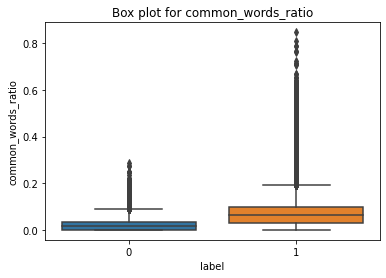

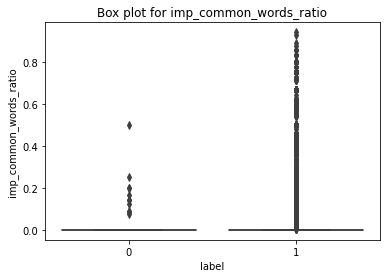

In [ ]:
sns.boxplot(x='label',y='common_words_ratio', data=model_dataset)
plt.title("Box plot for common_words_ratio")
plt.show()

sns.boxplot(x='label',y='imp_common_words_ratio', data=model_dataset)
plt.title("Box plot for imp_common_words_ratio")
plt.show()

As we can see from the above plots, feature common_words-ratio might be important for classification

In [ ]:
#save the dataset with additional features
model_dataset.to_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/data_for_model_4_features.pkl")

In [ ]:
model_dataset = pd.read_pickle("/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/data_for_model_4_features.pkl")

In [ ]:
ques_word_freq_corpus = pd.Series(' '.join(model_dataset.Ques_Text).split()).value_counts()

**Analyse word frequency to decide number of words to keep in corpus Vocabulary**

In [ ]:
ques_word_freq_corpus

not          1335531
code          696016
using         557516
like          497350
want          431002
              ...   
fritsch            2
rau                2
rosamond           2
orderder           2
wiremocks          2
Length: 233059, dtype: int64

In [ ]:
ques_word_freq_corpus[ques_word_freq_corpus.values>15]

not        1335531
code        696016
using       557516
like        497350
want        431002
            ...   
5467            16
hottest         16
xbd1            16
jrm             16
ooo             16
Length: 48883, dtype: int64

In [ ]:
ans_word_freq_corpus = pd.Series(' '.join(model_dataset.Ans_text).split()).value_counts()

In [ ]:
ans_word_freq_corpus

not              827425
use              481020
code             315470
like             280756
using            256031
                  ...  
x8ber                 1
x89to                 1
carrera               1
x89which              1
dialogeresult         1
Length: 199085, dtype: int64

We are keeping threshold of 15 i.e. words occuring more than 15 times in the corpus will be kept in the vocabulary.

In [ ]:
ans_word_freq_corpus[ans_word_freq_corpus.values>15]

not                     827425
use                     481020
code                    315470
like                    280756
using                   256031
                         ...  
stashing                    16
antisamy                    16
925                         16
unwire                      16
routevaluedictionary        16
Length: 28654, dtype: int64

**Analysis of Question and Answer text length to decide max length**

In [ ]:
ques_word_count = [len(str(x).split()) for x in list(model_dataset['Ques_Text'].values)]
for i in range(90,100):
    var = sorted(ques_word_count)
    #var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 92
91 percentile value is 95
92 percentile value is 99
93 percentile value is 104
94 percentile value is 110
95 percentile value is 117
96 percentile value is 125
97 percentile value is 137
98 percentile value is 154
99 percentile value is 190
100 percentile value is  6067


In [ ]:
ans_word_count = [len(str(x).split()) for x in list(model_dataset['Ans_text'].values)]
for i in range(90,100):
    var = sorted(ans_word_count)
    #var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 63
91 percentile value is 67
92 percentile value is 70
93 percentile value is 75
94 percentile value is 80
95 percentile value is 87
96 percentile value is 95
97 percentile value is 107
98 percentile value is 124
99 percentile value is 158
100 percentile value is  10140


Keeping max text length as 120 for both question and answer

In [ ]:
question_text = tf.data.Dataset.from_tensor_slices(list(model_dataset['Ques_Text'].values))

In [ ]:
ques_vocab_size = 45000
max_text_length = 120
ans_vocab_size = 28000

**Vectorize the text**

In [ ]:
vectorize_layer_ques = TextVectorization(standardize=None, max_tokens=ques_vocab_size, output_mode='int', output_sequence_length=max_text_length)
vectorize_layer_ques.adapt(question_text.batch(1024))

In [ ]:
# Vectorize all the questions in question_text.
question_text = question_text.batch(1024).prefetch(tf.data.AUTOTUNE).map(vectorize_layer_ques).unbatch()

In [ ]:
question_text = np.array(list(question_text.as_numpy_iterator()))

In [ ]:
answer_text = tf.data.Dataset.from_tensor_slices(list(model_dataset['Ans_text'].values))

In [ ]:
vectorize_layer_ans = TextVectorization(standardize=None, max_tokens=ans_vocab_size, output_mode='int', output_sequence_length=max_text_length)
vectorize_layer_ans.adapt(answer_text.batch(1024))

In [ ]:
# Vectorize all the answers in answer_text.
answer_text = answer_text.batch(1024).prefetch(tf.data.AUTOTUNE).map(vectorize_layer_ans).unbatch()

In [ ]:
answer_text = np.array(list(answer_text.as_numpy_iterator()))

In [ ]:
#standardize the numerical features
scaler = MinMaxScaler()
scaler.fit(model_dataset['common_words_ratio'].values.reshape(-1, 1))
common_words  = scaler.transform(model_dataset['common_words_ratio'].values.reshape(-1, 1))

In [ ]:
scaler = MinMaxScaler()
scaler.fit(model_dataset['imp_common_words_ratio'].values.reshape(-1, 1))
imp_common_words  = scaler.transform(model_dataset['imp_common_words_ratio'].values.reshape(-1, 1))

In [ ]:
#target labels
labels = model_dataset['label'].values.reshape(-1, 1)

In [ ]:
ds_size = model_dataset.shape[0]

In [ ]:
data = tf.data.Dataset.from_tensor_slices(((question_text, answer_text, common_words, imp_common_words), labels))


In [ ]:
path = "/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/model_tf.data.datasetObj"

In [ ]:
#save the dataset
tf.data.experimental.save(data, path)

In [ ]:
model_data = tf.data.experimental.load(path)

In [ ]:
model_data

<_LoadDataset element_spec=((TensorSpec(shape=(120,), dtype=tf.int64, name=None), TensorSpec(shape=(120,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.float64, name=None)), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

**Split the data in Train and Test and prepare the Train and Test datasets for further processing**

In [ ]:
#this function will aplit the dataset into train and test sets
def get_train_test_data(ds, ds_size, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=1170000):
    assert (train_split + test_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    
    return train_ds, test_ds

In [ ]:
train_data, test_data = get_train_test_data(model_data, ds_size)

In [ ]:
BATCH_SIZE = 512
BUFFER_SIZE_TR = 991161
BUFFER_SIZE_TE = 174911
train_data = train_data.shuffle(BUFFER_SIZE_TR).batch(BATCH_SIZE, drop_remainder=True)
test_data = test_data.shuffle(BUFFER_SIZE_TE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tf.keras.backend.clear_session()
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**LSTM based model**

In [ ]:
embedding_dim=128
ques_vocab_size = 45000
max_text_length = 120
ans_vocab_size = 28000

In [ ]:
#question text embedding
ques_text = Input(shape=(max_text_length,), name = 'ques_text')
ques_emb = tf.keras.layers.Embedding(input_dim=ques_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length, mask_zero=True, name='ques_emb')(ques_text)
ques_lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2,kernel_regularizer=L2(0.001),return_sequences=False)(ques_emb)

#answer text embedding
ans_text = Input(shape=(max_text_length,))
ans_emb = tf.keras.layers.Embedding(input_dim=ans_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length ,mask_zero=True, name='ans_emb')(ans_text)
ans_lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2,kernel_regularizer=L2(0.001),return_sequences=False)(ans_emb)

#dot layer to compute dot product(cosine similarity) between question and answer text
dot = tf.keras.layers.Dot(axes=1)([ques_lstm, ans_lstm])
flatten_1 = Flatten()(dot)

#numerical features
common_words = Input(shape=(1,) , name="common_words")
common_words_dense = Dense(100, activation='relu',kernel_regularizer=L2(0.001))(common_words )

imp_common_words = Input(shape=(1,) , name="imp_common_words")
imp_common_words_dense = Dense(100, activation='relu',kernel_regularizer=L2(0.001))(imp_common_words )

#concatenate the text dot product result with numerical features
conc_txt_numeric = concatenate([flatten_1, common_words_dense, imp_common_words_dense])

dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(conc_txt_numeric)
drp1 = tf.keras.layers.Dropout(0.2)(dense1)
flt = tf.keras.layers.Flatten()(drp1)
output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(flt)

model_lstm =Model(inputs=[ques_text, ans_text, common_words, imp_common_words], outputs=output)
model_lstm.summary()
model_lstm.compile(optimizer='adam', loss = BinaryCrossentropy(), metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ques_text (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 ques_emb (Embedding)           (None, 120, 128)     5760128     ['ques_text[0][0]']              
                                                                                                  
 ans_emb (Embedding)            (None, 120, 128)     3584128     ['input_1[0][0]']                
                                                                                              

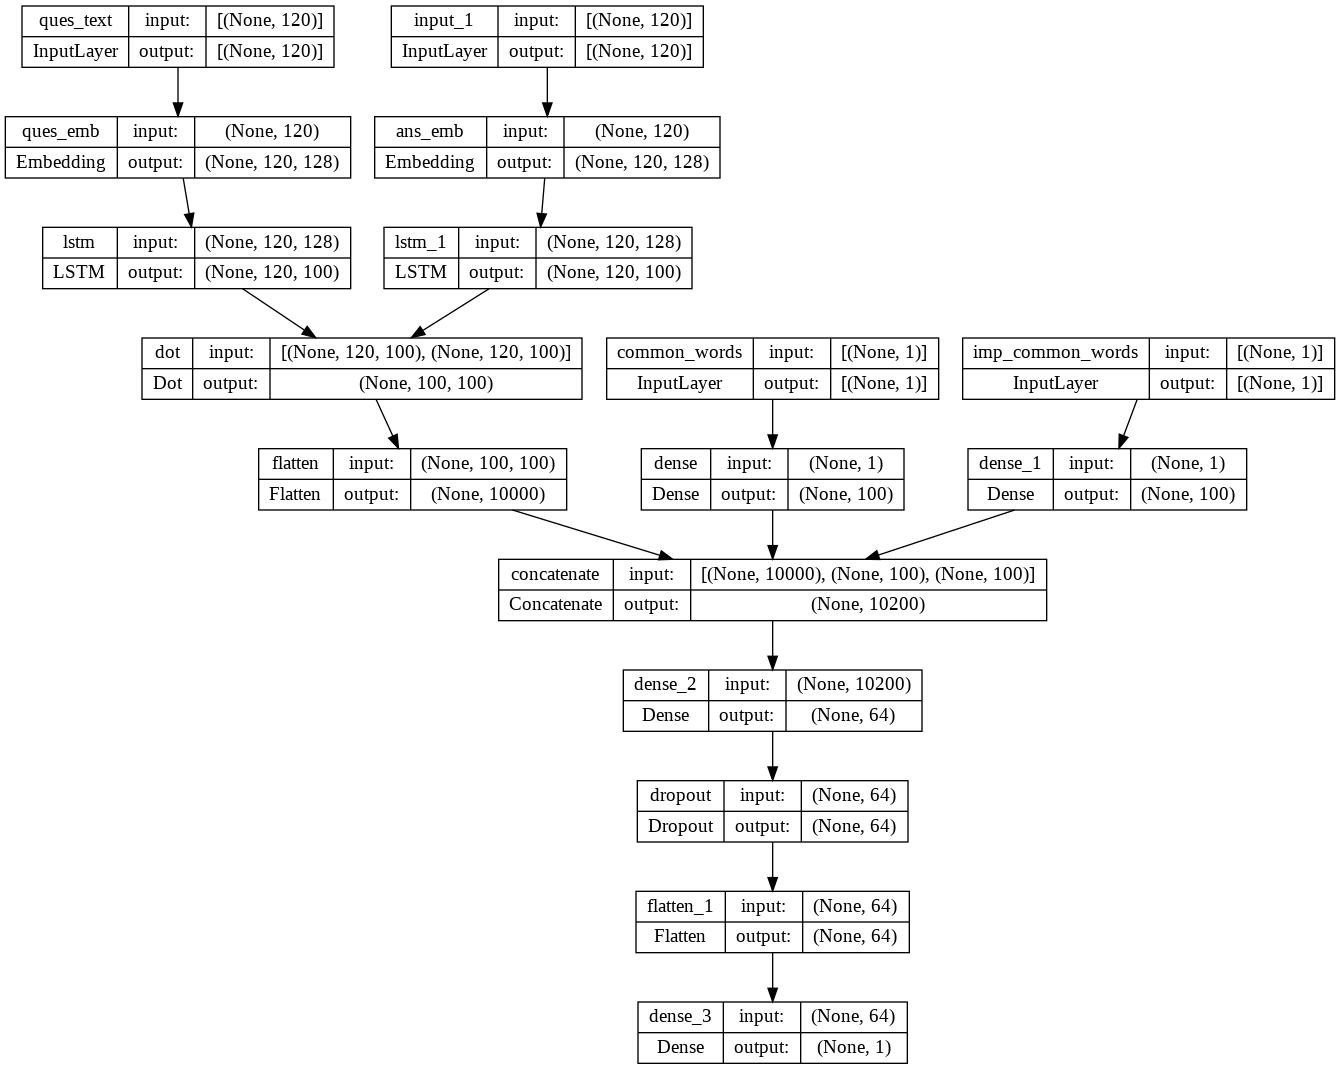

In [ ]:
tensorflow.keras.utils.plot_model(model_lstm,to_file = 'model1.png',show_shapes=True,show_layer_names=True)

In [ ]:
#Define required callbacks for model

logdir = "/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Log"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#callback to stop the training if validation accuracy is not increased in last 2 epochs
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)

filepath="/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
#callback to save model at every epoch if validation accuracy is improved from previous epoch
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

callbacks = [tensorboard_callback, earlystop, checkpoint]

In [ ]:
model_lstm.fit(train_data, validation_data=test_data, epochs=5, callbacks=callbacks)

Epoch 1/5
1935/1935 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.7825
Epoch 1: val_accuracy improved from -inf to 0.81913, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/weights-01-0.8191.hdf5
1935/1935 [==============================] - 1004s 496ms/step - loss: 0.4590 - accuracy: 0.7825 - val_loss: 0.3859 - val_accuracy: 0.8191
Epoch 2/5
1935/1935 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8213
Epoch 2: val_accuracy improved from 0.81913 to 0.83461, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/weights-02-0.8346.hdf5
1935/1935 [==============================] - 901s 466ms/step - loss: 0.3811 - accuracy: 0.8213 - val_loss: 0.3585 - val_accuracy: 0.8346
Epoch 3/5
1935/1935 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8456
Epoch 3: val_accuracy improved from 0.83461 to 0.84070, saving model to /content/drive/MyDrive/StackOverf

With this model, we got the best validation accuracy of 84.24%

**HyperParameter Tuning the lstm model (using Keras_Tuner):**

In [ ]:
def build_model(hp):
  ques_text = Input(shape=(max_text_length,), name = 'ques_text')
  ques = tf.keras.layers.Embedding(input_dim=ques_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length,mask_zero=True, name='ques_emb')(ques_text)
  
  #to find the number of lstm layers that can give best validation accuracy
  for i in range(hp.Int("num_lstm_layers", 1, 3)):
    #find best LSTM units, dropout rate and recurrent dropput rate
    ques = LSTM(units=hp.Int(f"lstm_un_1_{i}", min_value=32, max_value=128, step=32),
                    dropout=hp.Float(f"lstm_dr_1_{i}", min_value=.2, max_value=.4, step=.1),
                    recurrent_dropout=hp.Float(f"lstm_rec_dr_1_{i}", min_value=.2, max_value=.4, step=.1)
                    ,kernel_regularizer=L2(0.001),return_sequences=False)(ques)

  ans_text = Input(shape=(max_text_length,))
  ans = tf.keras.layers.Embedding(input_dim=ans_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length,mask_zero=True, name='ans_emb')(ans_text)
  #to find the number of lstm layers that can give best validation accuracy
  for i in range(hp.Int("num_lstm_layers", 1, 3)):
    #find best LSTM units, dropout rate and recurrent dropput rate
    ans = LSTM(units=hp.Int(f"lstm_un_2_{i}", min_value=32, max_value=128, step=32),
                    dropout=hp.Float(f"lstm_dr_2_{i}", min_value=.2, max_value=.4, step=.1),
                    recurrent_dropout=hp.Float(f"lstm_rec_dr_2_{i}", min_value=.2, max_value=.4, step=.1)
                    ,kernel_regularizer=L2(0.001),return_sequences=False)(ans)

  dot = tf.keras.layers.Dot(axes=1)([ques, ans])
  flatten_1 = Flatten()(dot)

  common_words = Input(shape=(1,) , name="common_words")
  common_words_dense = Dense(units=hp.Int("dense_un_com_w", min_value=32, max_value=64, step=32),
                             activation='relu',kernel_regularizer=L2(0.001))(common_words )

  imp_common_words = Input(shape=(1,) , name="imp_common_words")
  imp_common_words_dense = Dense(units=hp.Int("dense_un_imp_com_w", min_value=32, max_value=64, step=32),
                                 activation='relu',kernel_regularizer=L2(0.001))(imp_common_words )

  x = concatenate([flatten_1, common_words_dense, imp_common_words_dense])

  #find number of dense layers, no of units for dense layers and droput rate for best validation accuracy
  for i in range(hp.Int("num_dense_layers", 1, 3)):
    x = tf.keras.layers.Dense(units=hp.Int(f"dense_{i}", min_value=32, max_value=64, step=32), activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(rate=hp.Float(f"den_dr_{i}", min_value=.1, max_value=.4, step=.1))(x)
    
  output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

  model_lstm =Model(inputs=[ques_text, ans_text, common_words, imp_common_words], outputs=output)
  #model_lstm.summary()
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss = BinaryCrossentropy(), metrics=['accuracy'])
  return model_lstm

build_model(kt.HyperParameters())

In [ ]:
#Define all the required Callbacks

logdir = "/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Log"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#callback to stop the training if validation accuracy is not increased in last 2 epochs
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)

filepath="/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
#callback to save model at every epoch if validation accuracy is improved from previous epoch
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

callbacks = [tensorboard_callback, earlystop, checkpoint]

In [ ]:
#create the keras_tuner object
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=30, overwrite=False, hyperband_iterations=2,
                     project_name="untitled_project", directory="/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/HyperParameterTunedModel")


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 24
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
lstm_un_1_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
lstm_dr_1_0 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
lstm_rec_dr_1_0 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
lstm_un_2_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
lstm_dr_2_0 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
lstm_rec_dr_2_0 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
dense_un_com_w (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step

In [ ]:
#serach the hyperparameters for best accuracy
tuner.search(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Trial 17 Complete [01h 00m 14s]
val_accuracy: 0.7781035304069519

Best val_accuracy So Far: 0.8340058326721191
Total elapsed time: 06h 59m 16s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
3                 |1                 |num_lstm_layers
128               |64                |lstm_un_1_0
0.3               |0.3               |lstm_dr_1_0
0.3               |0.3               |lstm_rec_dr_1_0
96                |96                |lstm_un_2_0
0.4               |0.3               |lstm_dr_2_0
0.4               |0.3               |lstm_rec_dr_2_0
64                |64                |dense_un_com_w
64                |64                |dense_un_imp_com_w
64                |64                |dense_1
0.3               |0.4               |den_dr_1
0.0076576         |0.00067985        |lr
96                |96                |lstm_un_1_1
0.4               |0.3               |lstm_dr_1_1
0.2               |0.3               |lstm_rec_dr_1_1
64              

Epoch 1/2
1296/1821 [====================>.........] - ETA: 12:15 - loss: 0.5101 - accuracy: 0.7521

KeyboardInterrupt: ignored

In [ ]:
#get the model with best vlidation accuracy from keras_tuner object
best_model = tuner.get_best_models(1)[0]

In [ ]:
#get the model with best hyperparameters from keras_tuner object
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters

In [ ]:
best_lstm_model = build_model(best_hyperparameters)


In [ ]:
best_lstm_model.summary()

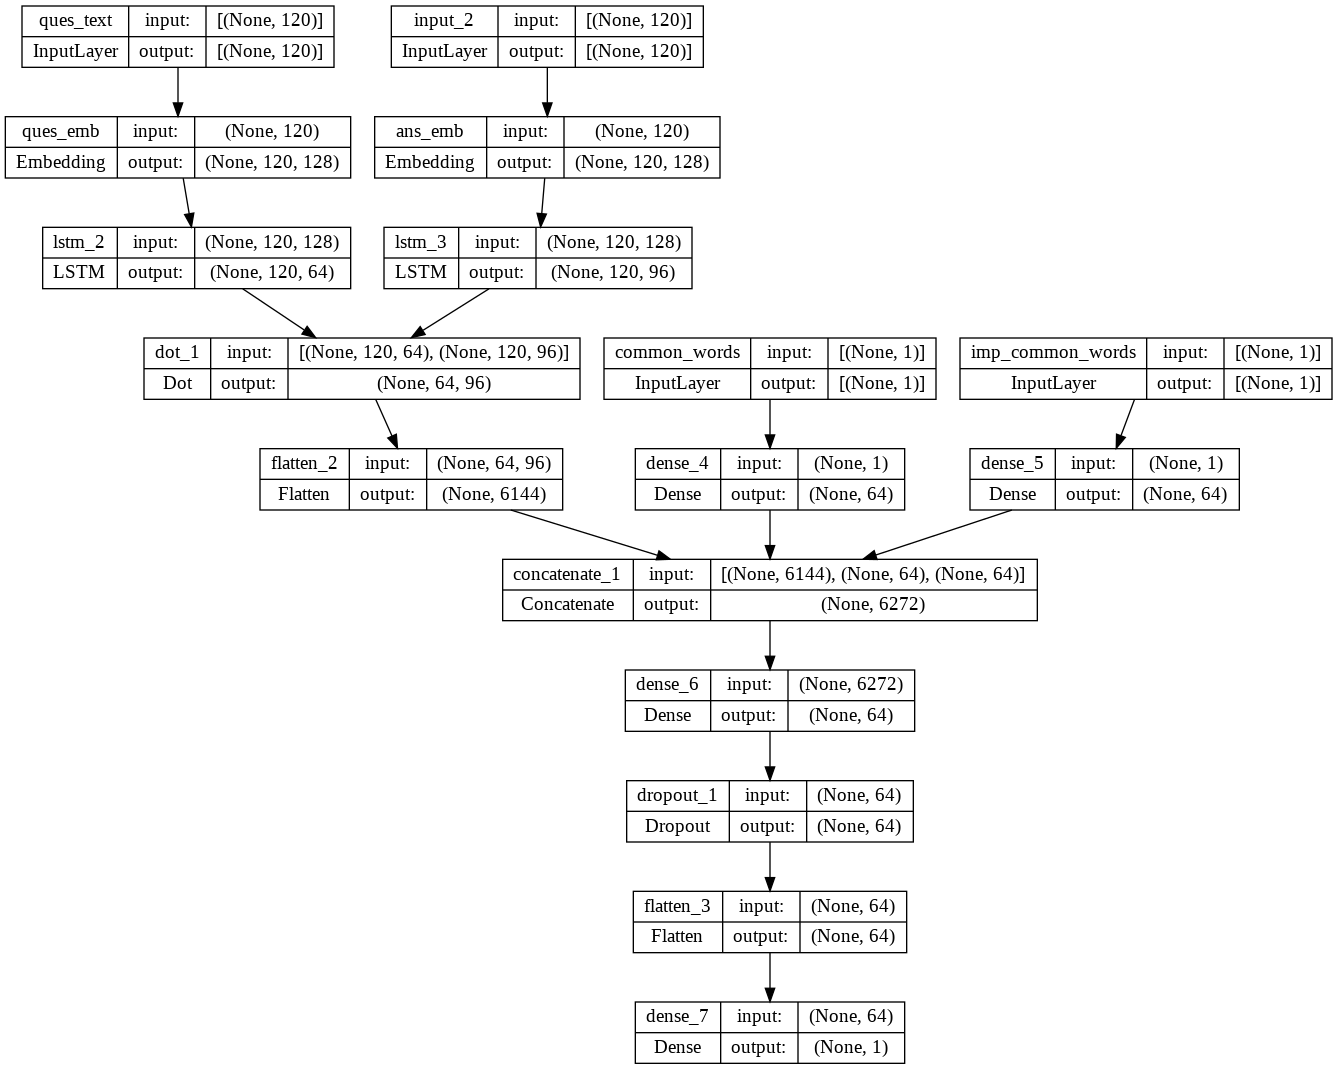

In [ ]:
tensorflow.keras.utils.plot_model(best_lstm_model,to_file = 'model1.png',show_shapes=True,show_layer_names=True)

In [ ]:
# train the best hyperparamter model for more epochs to improve the performance futher
best_lstm_model.fit(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Epoch 1/10
1821/1821 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.7734
Epoch 1: val_accuracy improved from -inf to 0.81196, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-01-0.8120.hdf5
1821/1821 [==============================] - 901s 493ms/step - loss: 0.4818 - accuracy: 0.7734 - val_loss: 0.4005 - val_accuracy: 0.8120
Epoch 2/10
1821/1821 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8100
Epoch 2: val_accuracy improved from 0.81196 to 0.82978, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-02-0.8298.hdf5
1821/1821 [==============================] - 896s 492ms/step - loss: 0.4028 - accuracy: 0.8100 - val_loss: 0.3670 - val_accuracy: 0.8298
Epoch 3/10
1821/1821 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8322
Epoch 3: val_accuracy improved from 0.82978 to 0.84302, saving model to /cont

With this we got the best validation accuracy of 84.71%

**Tuning last dense layers**

Broaden the search for the dense layer hyperparameters to see if we can futher imrove the validation accuracy of the model

In [ ]:
def build_model(hp):
  ques_text = Input(shape=(max_text_length,), name = 'ques_text')
  ques_emb = tf.keras.layers.Embedding(input_dim=ques_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length, mask_zero=True, name='ques_emb')(ques_text)
  ques_lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=True)(ques_emb)

  ans_text = Input(shape=(max_text_length,))
  ans_emb = tf.keras.layers.Embedding(input_dim=ans_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length ,mask_zero=True, name='ans_emb')(ans_text)
  ans_lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=True)(ans_emb)

  dot = tf.keras.layers.Dot(axes=1)([ques_lstm, ans_lstm])
  flatten_1 = Flatten()(dot)

  common_words = Input(shape=(1,) , name="common_words")
  common_words_dense = Dense(64, activation='relu',kernel_regularizer=L2(0.001))(common_words )

  imp_common_words = Input(shape=(1,) , name="imp_common_words")
  imp_common_words_dense = Dense(64, activation='relu',kernel_regularizer=L2(0.001))(imp_common_words )

  x = concatenate([flatten_1, common_words_dense, imp_common_words_dense])

  #search for number of denselayers, no. of units and activation function for each layer
  for i in range(hp.Int("num_dense_layers", 2, 3)):
    x = tf.keras.layers.Dense(units=hp.Int(f"dense_{i}", min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i}", ["relu", "tanh"]))(x)
    #find best dropout rate
    x = tf.keras.layers.Dropout(rate=hp.Float(f"den_dr_{i}", min_value=.2, max_value=.5, step=.1))(x)

  output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

  model_lstm =Model(inputs=[ques_text, ans_text, common_words, imp_common_words], outputs=output)
  #model_lstm.summary()
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss = BinaryCrossentropy(), metrics=['accuracy'])
  return model_lstm

build_model(kt.HyperParameters())


In [ ]:
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=100, overwrite=False, hyperband_iterations=2, project_name="untitled_project", directory="/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/HyperParameterTunedDenseLayers")


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
den_dr_0 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
den_dr_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dense_2

In [ ]:
tuner.search(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Trial 13 Complete [00h 29m 15s]
val_accuracy: 0.8372939825057983

Best val_accuracy So Far: 0.8521892428398132
Total elapsed time: 06h 29m 51s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
1                 |2                 |num_dense_layers
480               |128               |dense_0
tanh              |relu              |activation_0
0.5               |0.2               |den_dr_0
0.00013342        |0.00053067        |lr
480               |32                |dense_1
relu              |relu              |activation_1
0.3               |0.2               |den_dr_1
448               |None              |dense_2
relu              |None              |activation_2
0.4               |None              |den_dr_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round



Epoch 1/2
1821/1821 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.7705
Epoch 1: val_accuracy improved from -inf to 0.80494, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-01-0.8049.hdf5
1821/1821 [==============================] - 860s 470ms/step - loss: 0.5549 - accuracy: 0.7705 - val_loss: 0.4231 - val_accuracy: 0.8049
Epoch 2/2
 890/1821 [=============>................] - ETA: 6:57 - loss: 0.4289 - accuracy: 0.8003

In [ ]:
tuner.search(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Trial 15 Complete [00h 34m 22s]
val_accuracy: 0.8173720836639404

Best val_accuracy So Far: 0.8510473966598511
Total elapsed time: 08h 31m 08s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
3                 |2                 |num_dense_layers
224               |320               |dense_0
relu              |relu              |activation_0
0.3               |0.2               |den_dr_0
224               |128               |dense_1
relu              |tanh              |activation_1
0.4               |0.2               |den_dr_1
0.0054596         |0.00096705        |lr
32                |320               |dense_2
relu              |relu              |activation_2
0.4               |0.3               |den_dr_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round



Epoch 1/2
1723/1821 [===========================>..] - ETA: 51s - loss: 0.4902 - accuracy: 0.7662

Best validation accuracy we got from hyperparameter tuning is 85.1%. We will train the model with best hyperparameters for more epochs to see if validation accuracy can further improve.

In [ ]:
#get best hyperparameters from ablove search
best_hyperparameters_1 = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters_1.values

{'num_dense_layers': 2,
 'dense_0': 320,
 'activation_0': 'relu',
 'den_dr_0': 0.2,
 'dense_1': 128,
 'activation_1': 'tanh',
 'den_dr_1': 0.2,
 'lr': 0.0009670460155053197,
 'dense_2': 320,
 'activation_2': 'relu',
 'den_dr_2': 0.30000000000000004,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [ ]:
#create a model with best hyperparameters
best_lstm_model_1 = build_model(best_hyperparameters_1)


In [ ]:
best_lstm_model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ques_text (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 ques_emb (Embedding)           (None, 120, 128)     5760128     ['ques_text[0][0]']              
                                                                                                  
 ans_emb (Embedding)            (None, 120, 128)     3584128     ['input_2[0][0]']                
                                                                                            

In [ ]:
#train the model
best_lstm_model_1.fit(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Epoch 1/10
1821/1821 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.7873
Epoch 1: val_accuracy improved from -inf to 0.82736, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-01-0.8274.hdf5
1821/1821 [==============================] - 6353s 3s/step - loss: 0.4520 - accuracy: 0.7873 - val_loss: 0.3709 - val_accuracy: 0.8274
Epoch 2/10
1821/1821 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8319
Epoch 2: val_accuracy improved from 0.82736 to 0.85023, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-02-0.8502.hdf5
1821/1821 [==============================] - 6394s 4s/step - loss: 0.3617 - accuracy: 0.8319 - val_loss: 0.3304 - val_accuracy: 0.8502
Epoch 3/10
1821/1821 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8597
Epoch 3: val_accuracy improved from 0.85023 to 0.85477, saving model to /content/

The above training had stopped abruptly so getting best model and training it for few more epochs

In [ ]:
best_lstm_model_2 = tf.keras.models.load_model('/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-06-0.8652.hdf5')

In [ ]:
best_lstm_model_2.fit(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Epoch 1/10
1821/1821 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9103
Epoch 1: val_accuracy improved from -inf to 0.86417, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-01-0.8642.hdf5
1821/1821 [==============================] - 965s 510ms/step - loss: 0.2189 - accuracy: 0.9103 - val_loss: 0.3503 - val_accuracy: 0.8642
Epoch 2/10
1821/1821 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9185
Epoch 2: val_accuracy improved from 0.86417 to 0.86547, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-02-0.8655.hdf5
1821/1821 [==============================] - 878s 482ms/step - loss: 0.2017 - accuracy: 0.9185 - val_loss: 0.3505 - val_accuracy: 0.8655
Epoch 3/10
1821/1821 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9243
Epoch 3: val_accuracy improved from 0.86547 to 0.86562, saving model to /cont

We got the best validation accuracy of 86.56% from above model.

**BiLSTM with best parameters so far**

Trying Bidirectional lstm with the best hyperparameters we got from LSTM model

In [ ]:
#define the model with BiLSTM
ques_text = Input(shape=(max_text_length,), name = 'ques_text')
ques_emb = tf.keras.layers.Embedding(input_dim=ques_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length, mask_zero=True, name='ques_emb')(ques_text)
ques_lstm = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=True))(ques_emb)

ans_text = Input(shape=(max_text_length,))
ans_emb = tf.keras.layers.Embedding(input_dim=ans_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length ,mask_zero=True, name='ans_emb')(ans_text)
ans_lstm = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=True))(ans_emb)

dot = tf.keras.layers.Dot(axes=1)([ques_lstm, ans_lstm])
flatten_1 = Flatten()(dot)

common_words = Input(shape=(1,) , name="common_words")
common_words_dense = Dense(64, activation='relu',kernel_regularizer=L2(0.001))(common_words )

imp_common_words = Input(shape=(1,) , name="imp_common_words")
imp_common_words_dense = Dense(64, activation='relu',kernel_regularizer=L2(0.001))(imp_common_words )

conc_txt_numeric = concatenate([flatten_1, common_words_dense, imp_common_words_dense])

dense1 = tf.keras.layers.Dense(320, activation=tf.nn.relu)(conc_txt_numeric)
drp1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(128, activation=tf.nn.tanh)(drp1)
drp2 = tf.keras.layers.Dropout(0.2)(dense2)
output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(drp2)

model_bi_lstm_best =Model(inputs=[ques_text, ans_text, common_words, imp_common_words], outputs=output)
model_bi_lstm_best.summary()
model_bi_lstm_best.compile(tf.keras.optimizers.Adam(learning_rate=0.000967), loss = BinaryCrossentropy(), metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ques_text (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 ques_emb (Embedding)           (None, 120, 128)     5760128     ['ques_text[0][0]']              
                                                                                                  
 ans_emb (Embedding)            (None, 120, 128)     3584128     ['input_1[0][0]']                
                                                                                              

In [ ]:
model_bi_lstm_best.fit(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Epoch 1/10
1821/1821 [==============================] - ETA: 0s - loss: 0.4373 - accuracy: 0.7976
Epoch 1: val_accuracy improved from -inf to 0.83905, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-01-0.8390.hdf5
1821/1821 [==============================] - 1900s 1s/step - loss: 0.4373 - accuracy: 0.7976 - val_loss: 0.3476 - val_accuracy: 0.8390
Epoch 2/10
1821/1821 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8404
Epoch 2: val_accuracy improved from 0.83905 to 0.85683, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-02-0.8568.hdf5
1821/1821 [==============================] - 1779s 977ms/step - loss: 0.3458 - accuracy: 0.8404 - val_loss: 0.3190 - val_accuracy: 0.8568
Epoch 3/10
1821/1821 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.8683
Epoch 3: val_accuracy improved from 0.85683 to 0.86304, saving model to /conte

With above BiLSTM we got best validation accuracy of 86.41% which is still lesser than the best LSTM model.

**Hyperparameter Tune the above BiLSTM model further**

Trying hyperparametertuning the BiLSTM model to check if validation accuracy can improve further.

In [ ]:
#search for best units in BiLSTM, dropout, recurrent dropout, number of dense layer and number of units in each dense layer and activation function

def build_model(hp):
  ques_text = Input(shape=(max_text_length,), name = 'ques_text')
  ques = tf.keras.layers.Embedding(input_dim=ques_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length,mask_zero=True, name='ques_emb')(ques_text)
  lstm_units = hp.Int("lstm_units", min_value=64, max_value=256, step=32)
  ques = Bidirectional(LSTM(units=lstm_units,dropout=hp.Float("lstm_dr_1", min_value=.2, max_value=.4, step=.1),
                    recurrent_dropout=hp.Float("lstm_rec_dr_1", min_value=.2, max_value=.4, step=.1)
                    ,kernel_regularizer=L2(0.001),return_sequences=False))(ques)

  ans_text = Input(shape=(max_text_length,))
  ans = tf.keras.layers.Embedding(input_dim=ans_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length,mask_zero=True, name='ans_emb')(ans_text)
  ans = Bidirectional(LSTM(units=lstm_units, dropout=hp.Float("lstm_dr_2", min_value=.2, max_value=.4, step=.1),
                    recurrent_dropout=hp.Float("lstm_rec_dr_2", min_value=.2, max_value=.4, step=.1)
                    ,kernel_regularizer=L2(0.001),return_sequences=False))(ans)

  dot = tf.keras.layers.Dot(axes=1)([ques, ans])
  flatten_1 = Flatten()(dot)

  common_words = Input(shape=(1,) , name="common_words")
  common_words_dense = Dense(units=64, activation='relu',kernel_regularizer=L2(0.001))(common_words )

  imp_common_words = Input(shape=(1,) , name="imp_common_words")
  imp_common_words_dense = Dense(units=64, activation='relu',kernel_regularizer=L2(0.001))(imp_common_words )

  x = concatenate([flatten_1, common_words_dense, imp_common_words_dense])
  cnt =0
  for i in range(hp.Int("num_dense_layers", 1, 3)):
    x = tf.keras.layers.Dense(units=hp.Int(f"dense_{i}", min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i}", ["relu", "tanh"]))(x)
    x = tf.keras.layers.Dropout(rate=hp.Float(f"den_dr_{i}", min_value=.2, max_value=.5, step=.1))(x)
  
  output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

  model_bi_lstm_hyp =Model(inputs=[ques_text, ans_text, common_words, imp_common_words], outputs=output)
  #model_lstm.summary()
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model_bi_lstm_hyp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss = BinaryCrossentropy(), metrics=['accuracy'])
  return model_bi_lstm_hyp

build_model(kt.HyperParameters())

In [ ]:
#define all the required callbacks

logdir = "/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Log"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#callback to stop the training if validation accuracy is not increased in last 2 epochs
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)

filepath="/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/bi_lstm_hyp_tun_weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
#callback to save model at every epoch if validation accuracy is improved from previous epoch
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

callbacks = [tensorboard_callback, earlystop, checkpoint]

In [ ]:
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=100, overwrite=False, hyperband_iterations=2, project_name="untitled_project", directory="/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/HyperParameterTunedBiLSTM")


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 16
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
lstm_dr_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
lstm_rec_dr_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
lstm_dr_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
lstm_rec_dr_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', '

In [ ]:
tuner.search(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Trial 10 Complete [01h 08m 55s]
val_accuracy: 0.8003476858139038

Best val_accuracy So Far: 0.8065118193626404
Total elapsed time: 01h 08m 55s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
128               |64                |lstm_units
0.4               |0.4               |lstm_dr_1
0.4               |0.2               |lstm_rec_dr_1
0.4               |0.3               |lstm_dr_2
0.4               |0.4               |lstm_rec_dr_2
3                 |3                 |num_dense_layers
480               |64                |dense_0
tanh              |relu              |activation_0
0.2               |0.3               |den_dr_0
0.0036204         |0.0020444         |lr
224               |256               |dense_1
tanh              |tanh              |activation_1
0.2               |0.4               |den_dr_1
448               |416               |dense_2
tanh              |relu              |activation_2
0.2               |0.4               |den_dr_2

Epoch 1/2
 412/1821 [=====>........................] - ETA: 24:54 - loss: 0.5088 - accuracy: 0.7579

It did not give promising result so ignoring this hyperparameter search.

**Stacked LSTMs**

Trying 2 LSTM layers to see if it gives any promising results

In [ ]:
ques_text = Input(shape=(max_text_length,), name = 'ques_text')
ques_emb = tf.keras.layers.Embedding(input_dim=ques_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length, mask_zero=True, name='ques_emb')(ques_text)
ques_lstm_1 = LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=True)(ques_emb)
ques_lstm_2 = LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=False)(ques_lstm_1)

ans_text = Input(shape=(max_text_length,), name = 'ans_text')
ans_emb = tf.keras.layers.Embedding(input_dim=ans_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length, mask_zero=True, name='ans_emb')(ans_text)
ans_lstm_1 = LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=True)(ans_emb)
ans_lstm_2 = LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=False)(ans_lstm_1)

dot = tf.keras.layers.Dot(axes=1)([ques_lstm_2, ans_lstm_2])
flatten_1 = Flatten()(dot)

common_words = Input(shape=(1,) , name="common_words")
common_words_dense = Dense(64, activation='relu',kernel_regularizer=L2(0.001))(common_words )

imp_common_words = Input(shape=(1,) , name="imp_common_words")
imp_common_words_dense = Dense(64, activation='relu',kernel_regularizer=L2(0.001))(imp_common_words )

#imp_common_words = Input(shape=(1,) , name="imp_common_words")
conc_txt_numeric = concatenate([flatten_1, common_words_dense, imp_common_words_dense])
dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(conc_txt_numeric)
drp1 = tf.keras.layers.Dropout(0.4)(dense1)
dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu)(drp1)
drp2 = tf.keras.layers.Dropout(0.4)(dense2)
flt = tf.keras.layers.Flatten()(drp2)
output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(flt)

model_stacked_lstm =Model(inputs=[ques_text, ans_text, common_words, imp_common_words], outputs=output)
model_stacked_lstm.summary()
model_stacked_lstm.compile(tf.keras.optimizers.Adam(learning_rate=0.0007), loss = BinaryCrossentropy(), metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ques_text (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 ans_text (InputLayer)          [(None, 120)]        0           []                               
                                                                                                  
 ques_emb (Embedding)           (None, 120, 128)     5760128     ['ques_text[0][0]']              
                                                                                                  
 ans_emb (Embedding)            (None, 120, 128)     3584128     ['ans_text[0][0]']               
                                                                                            

In [ ]:
model_stacked_lstm.fit(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Epoch 1/10
3643/3643 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.7666
Epoch 1: val_accuracy improved from 0.74861 to 0.77865, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-01-0.7787.hdf5
3643/3643 [==============================] - 3268s 895ms/step - loss: 0.4905 - accuracy: 0.7666 - val_loss: 0.4531 - val_accuracy: 0.7787
Epoch 2/10
3643/3643 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.7781
Epoch 2: val_accuracy did not improve from 0.77865
3643/3643 [==============================] - 3333s 915ms/step - loss: 0.4621 - accuracy: 0.7781 - val_loss: 0.4576 - val_accuracy: 0.7781
Epoch 3/10
3643/3643 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.7937
Epoch 3: val_accuracy did not improve from 0.77865
3643/3643 [==============================] - 3328s 914ms/step - loss: 0.4404 - accuracy: 0.7937 - val_loss: 0.4899 - val_accuracy: 0.7695
Epoch 4/10


This is performing worse than single LSTM layers, so not exploring it further.

**CNN + LSTM model**

Trying CNN(Conv1D) with LSTM to see if it can increase performance further.

In [ ]:
#Define the model with Conv1D + LSTM layer for text features

ques_text = Input(shape=(max_text_length,), name = 'ques_text')
ques_emb = tf.keras.layers.Embedding(input_dim=ques_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length, mask_zero=True, name='ques_emb')(ques_text)
ques = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu',kernel_regularizer= L2(0.001))(ques_emb)
ques = MaxPool1D(3)(ques)
ques_lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=False)(ques)

ans_text = Input(shape=(max_text_length,))
ans_emb = tf.keras.layers.Embedding(input_dim=ans_vocab_size+1, output_dim=embedding_dim, input_length=max_text_length, mask_zero=True, name='ans_emb')(ans_text)
ans = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu',kernel_regularizer= L2(0.001))(ques_emb)
ans = MaxPool1D(3)(ans)
ans_lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=L2(0.001),return_sequences=False)(ans)

dot = tf.keras.layers.Dot(axes=1)([ques_lstm, ans_lstm])
flatten_1 = Flatten()(dot)

common_words = Input(shape=(1,) , name="common_words")
common_words_dense = Dense(64, activation='relu',kernel_regularizer=L2(0.001))(common_words )

imp_common_words = Input(shape=(1,) , name="imp_common_words")
imp_common_words_dense = Dense(64, activation='relu',kernel_regularizer=L2(0.001))(imp_common_words )

#imp_common_words = Input(shape=(1,) , name="imp_common_words")
conc_txt_numeric = concatenate([flatten_1, common_words_dense, imp_common_words_dense])
dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(conc_txt_numeric)
drp1 = tf.keras.layers.Dropout(0.4)(dense1)
dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu)(drp1)
drp2 = tf.keras.layers.Dropout(0.4)(dense2)
flt = tf.keras.layers.Flatten()(drp2)
output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(flt)

model_cnn_lstm =Model(inputs=[ques_text, ans_text, common_words, imp_common_words], outputs=output)
model_cnn_lstm.summary()
model_cnn_lstm.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss = BinaryCrossentropy(), metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ques_text (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 ques_emb (Embedding)           (None, 120, 128)     5760128     ['ques_text[0][0]']              
                                                                                                  
 conv1d_6 (Conv1D)              (None, 120, 16)      6160        ['ques_emb[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 120, 16)      6160        ['ques_emb[0][0]']               
                                                                                            

In [ ]:
model_cnn_lstm.fit(train_data, validation_data=test_data, epochs=10, callbacks=callbacks)

Epoch 1/10
3643/3643 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.7441
Epoch 1: val_accuracy improved from -inf to 0.74810, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-01-0.7481.hdf5
3643/3643 [==============================] - 580s 147ms/step - loss: 0.5270 - accuracy: 0.7441 - val_loss: 0.5139 - val_accuracy: 0.7481
Epoch 2/10
3643/3643 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.7454
Epoch 2: val_accuracy improved from 0.74810 to 0.74861, saving model to /content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-02-0.7486.hdf5
3643/3643 [==============================] - 505s 139ms/step - loss: 0.5212 - accuracy: 0.7454 - val_loss: 0.5132 - val_accuracy: 0.7486
Epoch 3/10
3643/3643 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.7454
Epoch 3: val_accuracy did not improve from 0.74861
3643/3643 [===============

Its performance is much worse than the LSTM based model so not exploring it further.

So far, we got best validation accuracy of 86.56% with hyperparamter tuned LSTM model, will use this model to get the word vectors.

**Get weight vecotors (from model with best accuracy) for all words in the vocabulary and create dictionary**

In [ ]:
#get best model
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Saved_Model/lstm_hyp_tun_weights-03-0.8656.hdf5')
#get weights of question_embedding layer
weights_ques = saved_model.get_layer('ques_emb').get_weights()[0]
#get questions_vocab
vocab_ques = vectorize_layer_ques.get_vocabulary()

In [ ]:
#get weights of answer_embedding layer
weights_ans = saved_model.get_layer('ans_emb').get_weights()[0]
#get answer_vocab
vocab_ans = vectorize_layer_ans.get_vocabulary()

In [ ]:
#create dictionary of word with their corresponding vectors for both question and answer vocabulary
ques_dict = dict(zip(vocab_ques, weights_ques))
ans_dict = dict(zip(vocab_ans, weights_ans))

In [ ]:
#keep vectors of words commom in question and answer from questions dictionary, keep the words only available in answers vocabulary from answers dictionary
ans_dict.update(ques_dict)

In [ ]:
#final vocab dictionary
lstm_vocab_vector_dict = ans_dict

In [ ]:
#save the dictionary
pickle.dump(lstm_vocab_vector_dict, open("/content/drive/MyDrive/StackOverflow_CaseStudy/Model2_data/Best_LSTM_Model_Vocab_Vector_dict.pkl", "wb"))